## Assignment 2: Classification and locally weighted regression  
### CS 4262/5262 (Foundations of Machine Learning)<br><br>Vanderbilt University, Spring 2022<br><br>Due: Check Brightspace
---
<br>This assignment will focus on logistic regression (for binary classification) and locally weighted linear regression. For each algorithm, we have provided a class framework as a suggestion, but you are not required to use those in your implementation. Please use good programming practices - include informative comments and vectorize operations whenever possible. In addition to programming tasks, there are short-answer questions throughout the notebook. 

As always, please do not hesitate to ask us for clarifications. 

In [1]:
import csv
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import scipy as sp
from sklearn import datasets
import pandas as pd
import seaborn as sns
import random

--- 
## Part 0: Data


You will be applying binary classification to two different datasets: the [Iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) dataset and the wine quality dataset (Data Source :https://archive.ics.uci.edu/ml/datasets/Wine+Quality). The Iris dataset is smaller and simpler, and therefore may be useful for debugging. This dataset consists of measurements (septal and petal length and width) of 50 samples from each of 3 species of Iris flower. The wine quality dataset is more complex, and the classification task is to predict whether a sample should be red wine or white wine given the feature.

**Task 1**
- Load the Iris dataset from scikit-learn. (refer to [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html))
- Here, we will represent each sample by 2 of the 4 available features: petal width and petal length. 
- Display a scatterplot of the data, such that: 
    * the x- and y- axes correspond to the two features (petal width, petal length)
    * the axes are labelled 
    * points are colored according to class membership
    * the legend describes which iris type (class) is represented by each color

**Question 1:  Which classes appear to be linearly separable in this feature space?**

Response: Based on the plot below, the Setosa class appears to be linearly separable from the other two classes. We could easily isolate the Setosa data from the rest of the data by plotting a line.

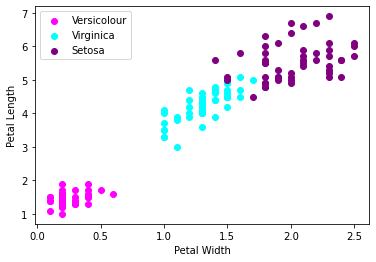

In [2]:
#TODO - Iris dataset
%matplotlib inline
iris = datasets.load_iris()
# iris_header = iris.feature_names
iris_y = iris.target
widths = iris.data[:, 3]
lengths = iris.data[:, 2]

plt.scatter(widths[iris_y == 0], lengths[iris_y == 0], color ='magenta')
plt.scatter(widths[iris_y == 1], lengths[iris_y == 1], color ='cyan')
plt.scatter(widths[iris_y == 2], lengths[iris_y == 2], color ='purple')

plt.xlabel('Petal Width')
plt.ylabel('Petal Length')
plt.legend(['Versicolour', 'Virginica', 'Setosa'], loc='best')

**Task 2**
- Load the wine dataset given in the brightspace. The file is named `wine_quality.npy`
    * we have 1600 lines of white wine data and 1599 lines of red wine data
    * white/red wine is labeled as 0/1
    * each sample has 11 dimensions of features
- Here, we will represent each sample by 3 features (using mpl_toolkits.mplot3d.Axes3D): 
- Similar to the Iris dataset, display a scatterplot of the data such that: "volatile acidity", "fixed acidity", and "residual sugar".
    * the x-, y-, and z- axes correspond to the features
    * the axes are labelled 
    * the sample point is colored based on the class
    * the legend specifies the label associated with each color

<IPython.core.display.Javascript object>


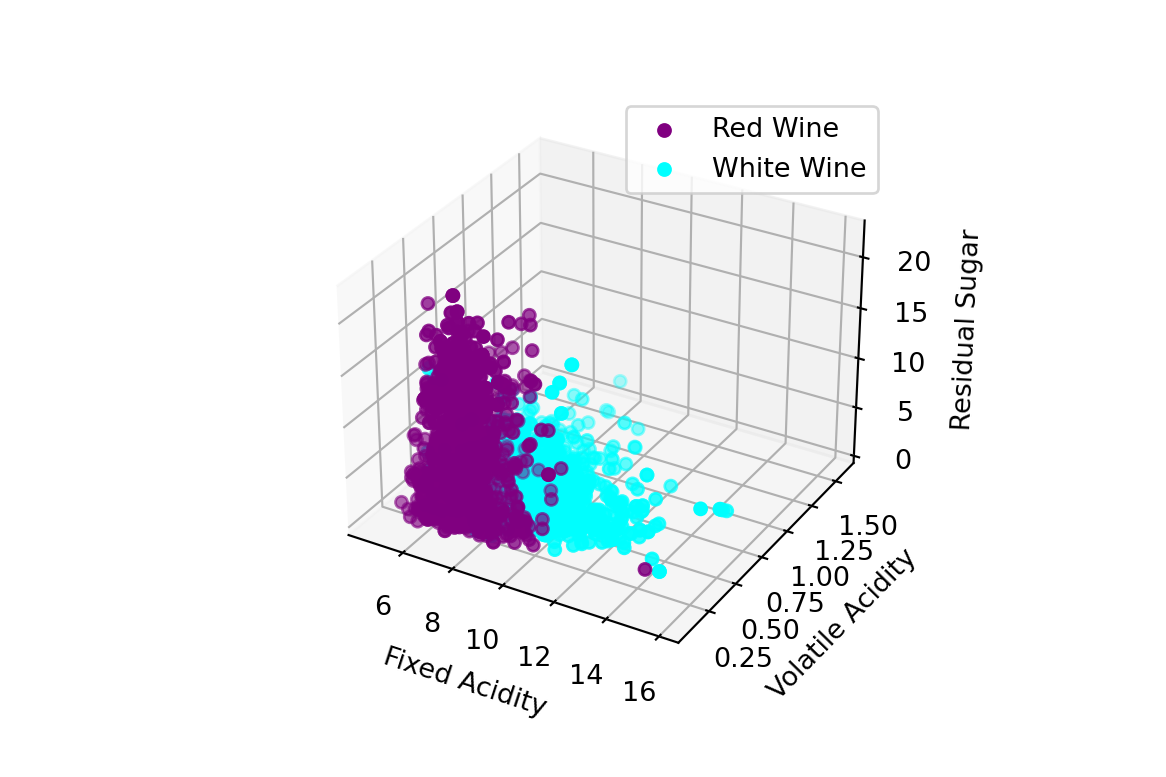

In [32]:
#TODO - wine quality dataset
# %matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

wine_qual = np.load('wine_quality.npy')
wine_y = wine_qual[:, 11]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(wine_qual[:,0][wine_y == 0], wine_qual[:,1][wine_y == 0], wine_qual[:,3][wine_y == 0], color = "purple")
ax.scatter3D(wine_qual[:,0][wine_y == 1], wine_qual[:,1][wine_y == 1], wine_qual[:,3][wine_y == 1], color = "cyan")

ax.set_xlabel('Fixed Acidity')
ax.set_ylabel('Volatile Acidity')
ax.set_zlabel('Residual Sugar')
plt.legend(['Red Wine', 'White Wine'], loc='best')
plt.show()

**Task 3**

There are many dimensions of the features, use `sns.PairGrid()` to plot out the pairwise feature relationship on both iris and wine dataset. 

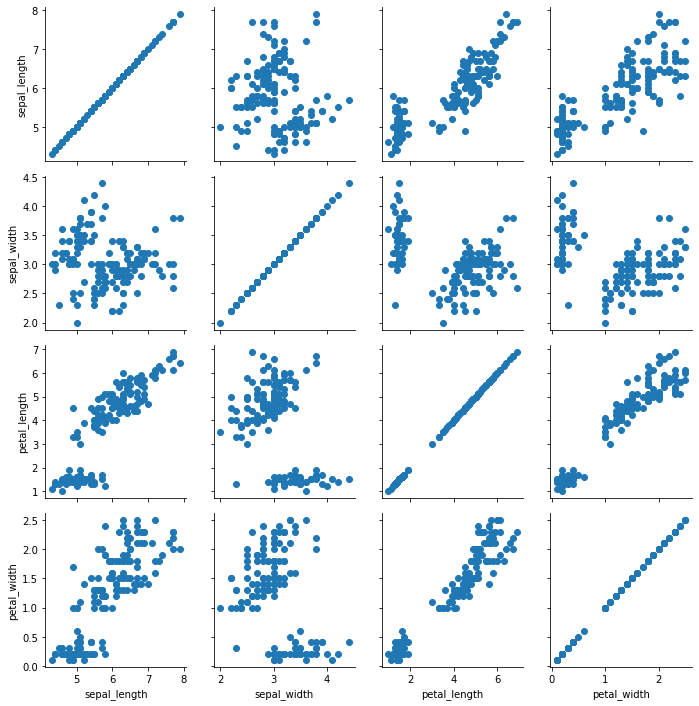

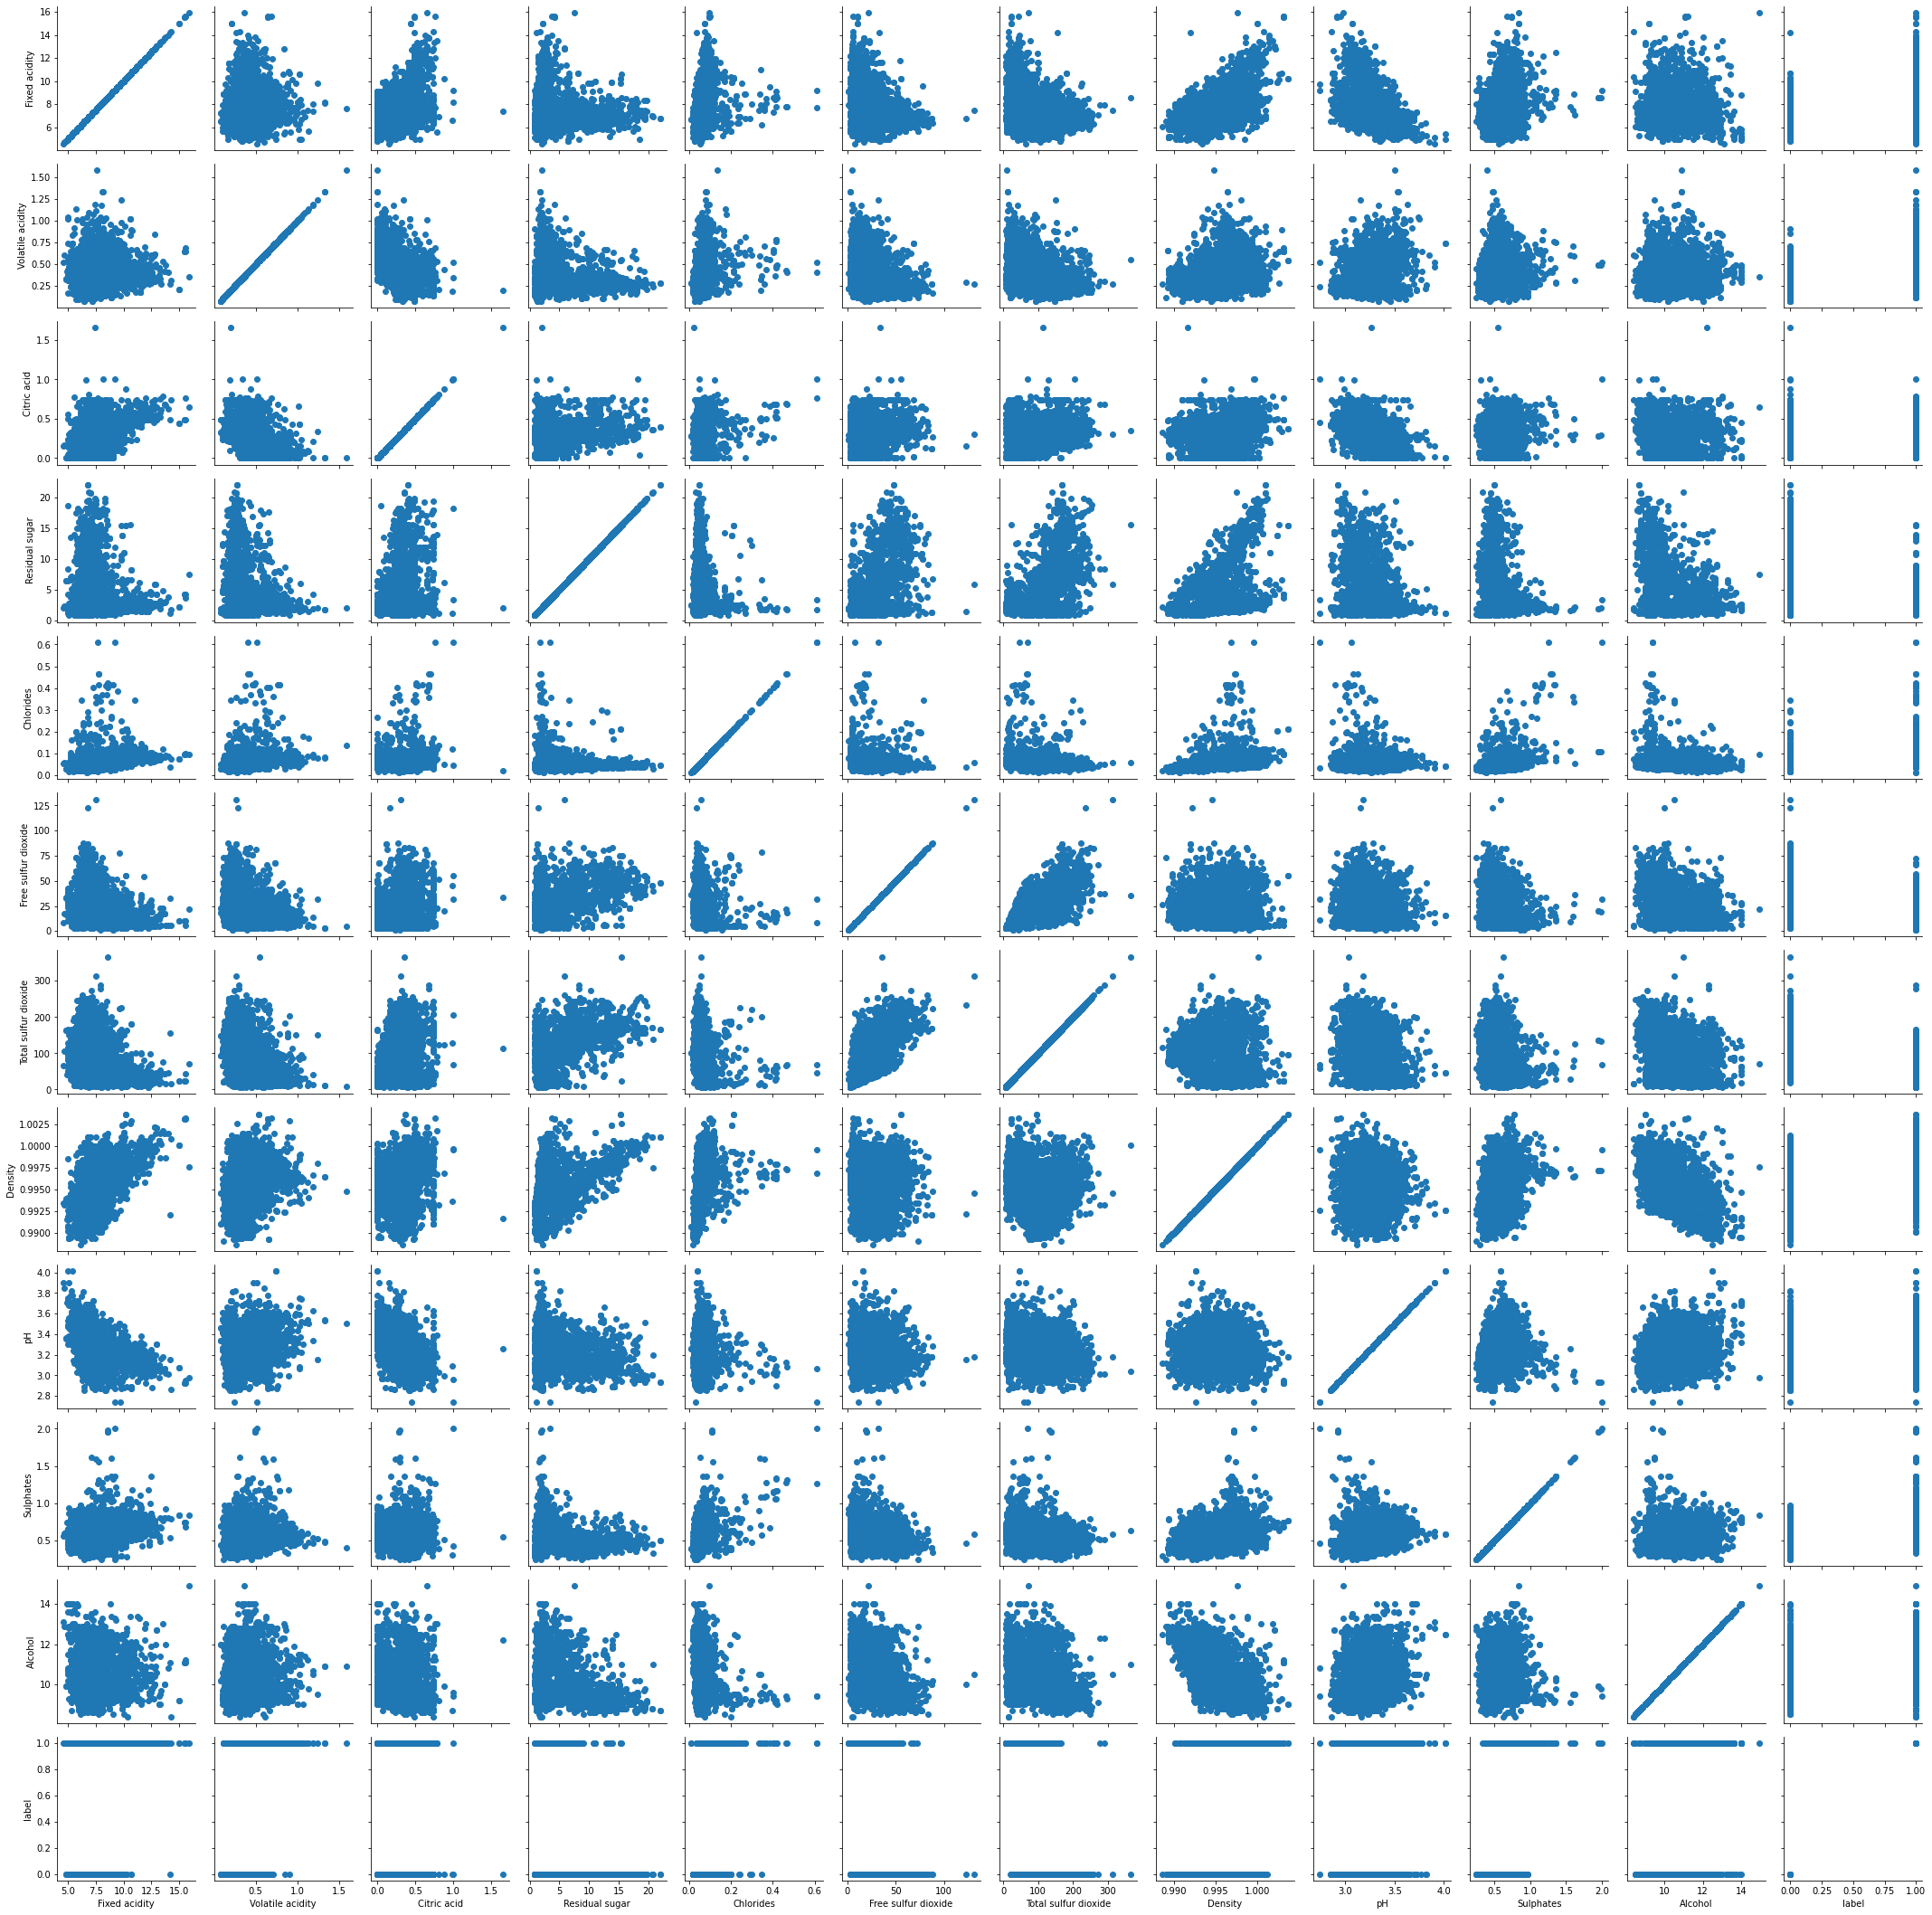

In [4]:
#TODO pairwise plot on 2 dataset

iris_df = sns.load_dataset('iris')
iris_grid = sns.PairGrid(iris_df)
iris_grid.map(plt.scatter);
plt.show()


wine_df = pd.DataFrame(wine_qual, columns=['Fixed acidity', 'Volatile acidity', 'Citric acid', 'Residual sugar', 
                                                    'Chlorides', 'Free sulfur dioxide', 'Total sulfur dioxide','Density', 
                                                    'pH', 'Sulphates', 'Alcohol', 'label'])
wine_grid = sns.PairGrid(wine_df)
wine_grid.map(plt.scatter);
plt.show()

**Question 2:**

 2.1 Comment on the plots from the wine dataset, compared to the kinds of plots you saw in the Iris dataset. What similarities or differences do you see? What does the PairGrid visualization help to do?

Response: Ignoring the plots for which the x and y variables are the same, all of the iris dataset plots appear to be linearly separable, whereas most of the wine dataset plots seem to be linearly separable. The PairGrid visualization is extremely useful for determining the linear separability of datasets with large numbers of features.

 2.2 Discuss separability of the wine dataset, based on what you have seen so far. Is it separable in two features? Do you think multiple features would change this outcome?

Response: The wine dataset is not separable in any two features. Multiple features should not change this outcome, as we have already plotted all possible pairings of the 11 features in the dataset, and none of these data pairings appear to be separable.

---
## Part 1: Logistic Regression

The first classification algorithm you will implement is Logistic Regression (for binary classification). You do not have to use the class framework provided below, but please make sure to organize and comment your code clearly. 

**Task 4**
Write a LogisticRegression class such that:
 - parameters ($\theta$) are optimized using gradient descent 
 - there is an `evaluate` method that returns the model's accuracy on a given set of data
 - there is a `learning curve` method that plots the cost function against the number of iterations
 - there is a `decision boundary` method that renders a plot of the training data with the decision boundary overlayed (note: this code is provided for you below - make sure you understand how it works) 
 - please vectorize operations as much as possible

In [24]:
#TODO - implement LogisticRegression class

class LogisticRegression():
    
    def __init__(self, X, y, theta, alpha):
        self.X = X
        self.y = y
        self.theta = theta 
        self.alpha = alpha
    
    #  h (hypothesis): returns p(y=1|x) on inputs contained in the design matrix X
    def sigmoid(self, X): 
        return 1 / (1 + math.e ** -(self.theta @ X.T))
    
    # return predictions of class membership (0,1) of the datapoints in an input matrix X
    def predict(self, X):
        pred = []
        c  = self.sigmoid(X)
        for y_i in c:
            if y_i >= 0.5:
                pred.append(1)
            else:
                pred.append(0)
        return pred
    
    # cost function J()
    def cost(self):
        return -1 * ((self.y @ np.array(np.log(self.sigmoid(self.X))) + ((1 - self.y) @ np.log(1 - self.sigmoid(self.X))))) / len(self.y)
    
    # update theta 
    def gradient_descent_step(self):
        #gradient = np.array(np.shape(self.theta), dtype='float64')
        #gradient = np.sum((self.sigmoid(self.X) - self.y.T) @ self.X)
        gradient = (self.X.T @ (self.sigmoid(self.X) - self.y).T) / len(self.y)
        self.theta -= (self.alpha * gradient.T[0])
    
    # define a convergence criterion 
    # run gradient descent until convergence 
    def run_gradient_descent(self, threshold=0.001):
        J = []
        J_prev = 0
        iters = 0
        while (iters < 1000) and abs(J_prev - self.cost()) > threshold:
            J_prev = self.cost()
            J.append(J_prev)
            self.gradient_descent_step()
            iters += 1
        return J
    
    # return the model's accuracy on an input (X,y) dataset 
    def evaluate(self, X, y):
        matches = 0
        
        preds = self.predict(X)
        for i in range(len(y)):
            if (preds[i] == y[i]):
                matches += 1       
        return (matches / len(y))
    
    # plot cost function over num gradient descent steps
    def learning_curve(self, losses):
        plt.plot(range(len(losses)), losses)
        plt.title('Learning Curve')
        plt.xlabel('Number of Steps')
        plt.ylabel('MSE Loss')
        plt.show()
    
    # plot decision boundary, based on current model parameters
    # you may edit or add cases to this, to accommodate plotting the Iris data too
    def decision_boundary(self, dset, x_var='', y_var=''):
        X = self.X[:,1:]
        theta = self.theta
        y = np.reshape(self.y, (-1))
        xax = [np.min(X[:, 0]), np.max(X[:, 0])]
        yax = -1.0*(theta[0] + np.dot(theta[1], xax)) / theta[2]
        plt.scatter(x=X[y==0,0],y=X[y==0,1],c='red',edgecolor='black')
        plt.scatter(x=X[y==1,0],y=X[y==1,1],c='blue',edgecolor='black')
        plt.plot(xax, yax)
        if dset=='wine':
            plt.legend(['red','white', 'decision boundary'])
            plt.xlabel(x_var)  # name it as the your input x- and y-
            plt.ylabel(y_var)
            plt.title('Wine')
        elif dset=='iris':
            plt.legend(['decision boundary','setosa','versicolor'])
            plt.xlabel('petal width')
            plt.ylabel('petal length')
            plt.title("Iris Dataset")            
        plt.show()

**Task 5**
Verify that your method works on the Iris dataset. The Iris dataset is originally a 3-class dataset, but for this purpose, please select two of the 3 classes on which to perform binary classification (and again, use the 2 features "petal length" and "petal width"). You do not have to split this dataset further into training and testing sets.
 - Display the decision boundary, superimposed on the scatterplot of the data

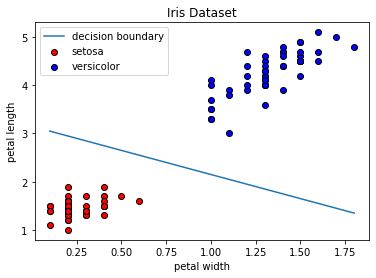

Training Accuracy: 100.0 %


In [6]:
# TODO Task 5
iris_X = []
iris_y = []
for i in range(150):
    if iris.target[i] != 2:
        iris_X.append([1, iris.data[i][3], iris.data[i][2]])
        iris_y.append(iris.target[i])
        
        
iris_logreg = LogisticRegression(np.array(iris_X), np.array(iris_y), np.array([1.0,5.0,5.0]), 0.45)
losses = iris_logreg.run_gradient_descent()
iris_logreg.decision_boundary('iris')


print('Training Accuracy:', iris_logreg.evaluate(np.array(iris_X), np.array(iris_y)) * 100, '%')

**Task 6**
Explore your method on the wine dataset, expanding from 2 dimensions into multiple dimensions.
 - Split the wine dataset into a training set and a test set (80/20 split). We recommend shuffling the data first.
 - Then, perform feature scaling (standardizing to mean = 0 and variance = 1) on both the training and test sets. Please write your own function to perform this standardization, rather than using a module from scikit-learn. Note that it is recommended to calculate the scaling parameters (mean and variance) from the training set, and then apply those same paramters to scale the test set, so that the test set does not influence the training in any way. 
 - **we are not expecting to get 100% accuracy on any of the feature combinations**, but an empirical lower bound for the accuracy is given. That is to say, your approach is probably right, as long as your performance on the test set is higher than the number.
 - Train your model on the wine training data with the following 4 [feature combinations] : percentage to beat during test
   * [fixed acidity, volatile acidity, residual sugar] : 85%
   * [density, pH, alcohol] : 95%
   * [fixed acidity, volatile acidity, chlorides] : 85%, 
   * [all 11 features]: 95%
   * note that the features list is: fixed acidity/volatile acidity/citric acid/residual sugar /chlorides/free sulfur dioxide/total sulfur dioxide/density/pH/sulphates/alcohol
 - Display the decision boundary plots (plot in 2d, so please just choose any 2 of your features as x- and y-). 
 - Display plots of the learning curve 
 - Report the model's final accuracy on the test set

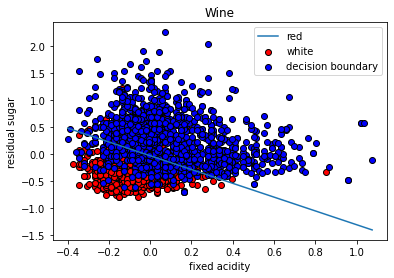

Training Accuracy: 91.71875 %


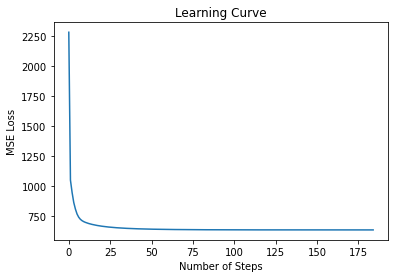

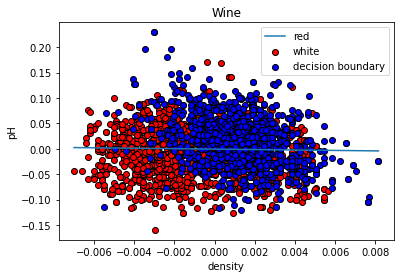

Training Accuracy: 66.09375 %


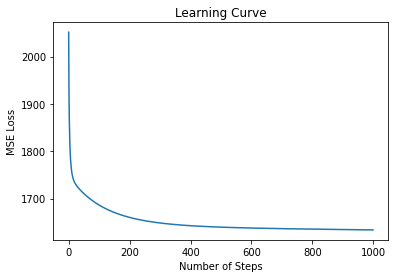

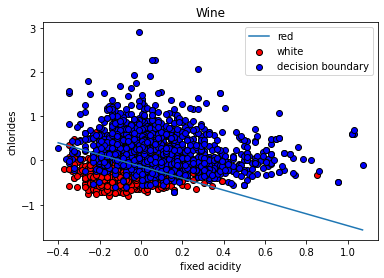

Training Accuracy: 93.4375 %


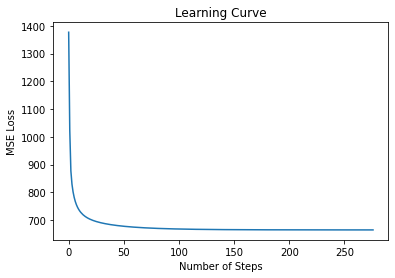

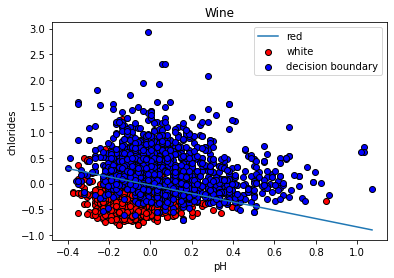

Training Accuracy: 98.125 %


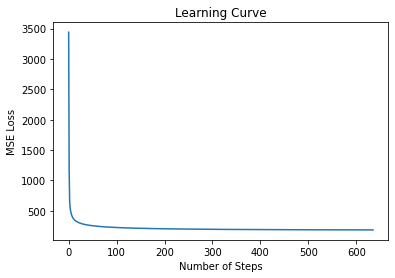

In [23]:
#TODO - Task 6, apply your method to the wine dataset
import warnings
warnings.filterwarnings("ignore")

def split_train_test(x, y):
    xy = list(zip(x, y))
    random.shuffle(xy)
    x, y = zip(*xy)
    
    split = int(len(x)*0.8)
    train_x = np.array(x[:split])
    train_y = np.array(y[:split])
    test_x = np.array(x[split:])
    test_y = np.array(y[split:])
    
    train_y = np.reshape(train_y, (len(train_y),1))
    test_y = np.reshape(test_y, (len(test_y),1))
    
    return train_x, train_y, test_x, test_y


def form_design_matrix(training_inputs, degree):
    x1 = np.ones((len(training_inputs),1))
    return np.hstack((x1 , training_inputs))


def standardize_data(train_data, test_data):
    for i in range(len(train_data[0])):
        mean = np.mean(train_data[:,i])
        
        train_data[:,i] -= mean
        train_data[:,i] /= mean
        
        test_data[:,i] -= mean
        test_data[:,i] /= mean
        
    return train_data, test_data


# fixed acidity, volatile acidity, residual sugar
train_x, train_y, test_x, test_y = split_train_test(wine_qual[:, [0,1,3]], wine_qual[:, 11])
std_train_x, std_test_x = standardize_data(train_x, test_x)

wine_1 = LogisticRegression(form_design_matrix(std_train_x,3), train_y.T, np.array([1.0, 1.0, 1.0, 1.0]), 0.005)
losses = wine_1.run_gradient_descent()
wine_1.decision_boundary('wine', 'fixed acidity', 'residual sugar')

print('Training Accuracy:', wine_1.evaluate(form_design_matrix(std_test_x,3), test_y.T[0]) * 100, '%')
wine_1.learning_curve(losses)


# density, pH, alcohol
train_x, train_y, test_x, test_y = split_train_test(wine_qual[:, [7,8,10]], wine_qual[:, 11])
std_train_x, std_test_x = standardize_data(train_x, test_x)

wine_2 = LogisticRegression(form_design_matrix(std_train_x,3), train_y.T, np.array([1.0, 1.0, 1.0, 1.0]), 0.003)
losses = wine_2.run_gradient_descent()
wine_2.decision_boundary('wine', 'density', 'pH')

print('Training Accuracy:', wine_2.evaluate(form_design_matrix(std_test_x,3), test_y.T[0]) * 100, '%')
wine_2.learning_curve(losses)


# fixed acidity, volatile acidity, chlorides
train_x, train_y, test_x, test_y = split_train_test(wine_qual[:, [0,1,4]], wine_qual[:, 11])
std_train_x, std_test_x = standardize_data(train_x, test_x)

wine_3 = LogisticRegression(form_design_matrix(std_train_x,3), train_y.T, np.array([1.0, 1.0, 1.0, 1.0]), 0.003)
losses = wine_3.run_gradient_descent()
wine_3.decision_boundary('wine', 'fixed acidity', 'chlorides')
print('Training Accuracy:', wine_3.evaluate(form_design_matrix(std_test_x,3), test_y.T[0]) * 100, '%')

wine_3.learning_curve(losses)


# all 11 features
train_x, train_y, test_x, test_y = split_train_test(wine_qual[:, 0:11], wine_qual[:, 11])
std_train_x, std_test_x = standardize_data(train_x, test_x)

wine_4 = LogisticRegression(form_design_matrix(std_train_x,11), train_y.T, np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), 0.001)
losses = wine_4.run_gradient_descent()
wine_4.decision_boundary('wine', 'pH', 'chlorides')
print('Training Accuracy:', wine_4.evaluate(form_design_matrix(std_test_x,11), test_y.T[0]) * 100, '%')

wine_4.learning_curve(losses)

**Question 3:**

 3.1. Describe the convergence condition you selected.

Response: I used a threshold value of 0.001 to determine convergence. Once the current loss value is within 0.001 of the previous loss value, covergence has been reached.

 3.2. What was the model's training accuracy on the Iris dataset (for the two classes you selected)?

Response: The model's training accuracy on the Iris dataset was 100%.

 3.3. What was the model's training and test accuracy on the wine quality dataset? Which one gives the best performance? Does that live up to your expectation and why?

Response: The training accuracies were ~92%, ~66%, ~93%, and ~98%, respectively. The model with the training set of all 11 features performed the best, with an accuracy of 98.125%. This percentage was a lot higher than I expected because this dataset is not separable, as we observed earlier in this assignment. As such, it did not seem likely that this method of regression would be effective in training the model.

---
## Part 2: Locally Weighted Linear Regression 

In this second part, you will write a locally weighted linear regression class, and apply it to a synthetic dataset. This dataset is included as a text file on Brightspace, and is called 'LWR_samples.npy'. Each line of the text file represents one training example in the format $x^{(i)},y^{(i)}$ (i.e. the delimiter is a comma). 

#### **Task 5**
- Load and plot the synthetic data, named `LWR_Samples.npy`
- Implement a LocallyWeightedLR class (example framework below). To make a prediction at input $x$, weight each training example according to the function we discussed in lecture: 
$$ w^{(i)} = \exp\big(-\frac{(x^{(i)} - x)^2}{2\tau^2} \big), $$
where $\tau$ is a bandwidth parameter that you will experiment with.
- To compute the local linear regression parameters ($\theta$) at each query point, use the closed-form solution. The formula is:
$$ \theta = (X^TWX)^{-1} X^TWy, $$
where $X$ is the design matrix formed by your training inputs (make sure to include the intercept term), $W$ is a diagonal matrix whose $i^{th}$ diagonal entry corresponds to the weight of the $i^{th}$ training example (which depend on the point at which you are making a prediction), and $y$ is a column vector containing the target labels of the training examples.

- Run this regression model to make predictions at the specific input points x = 4, x = 0.5, and x = -3. Use $\tau$ = 0.5. Report the values of the local regression parameters $\theta$ obtained for each of these 3 points.
- Now, generate an array of predictions corresponding to equally spaced input points (in the range of [-4.5, 4.5] in steps of 0.05), again using $\tau$ = 0.5. Generate a plot showing the predictions from Locally Weighted Linear Regression on each of these input points, superimposed on (and colored differently from) the training data.
- Repeat the previous step, now using bandwidth parameters $\tau = 0.1$ and $\tau = 1.5$. Plot the results, again superimposed on the training data (and in a different color).

In [29]:
#TODO - Task 5, implement Locally-Weighted Linear Regression class

class LocallyWeightedLR():
    
    def __init__(self, X, y, tau):
        self.X = X
        self.y = y
        self.tau = tau
        
    # use bandwidth variable tau to compute weights for each training point.  
    # return a diagonal matrix with w_i on the diagonal (for vectorization)
    # note that the values of w_i depend upon the value of the input query point x.
    def compute_weights(self, x):
        w = np.zeros((len(self.X), len(self.X)))
        
        for i in range(len(self.X)):
            w[i][i] = math.e**((-1/2) * ((self.X[i][1] - x)**2) / ((self.tau)**2))
        return w
    
    # analytical solution for the local linear regression parameters at the input query point x.
    # this should involve calling the above method compute_weights.
    def compute_theta(self, x):
        w = self.compute_weights(x)
        return np.linalg.inv(self.X.T @ w @ self.X) @ self.X.T @ w @ self.y
    
    # prediction for an input x
    # also return the local linear regression parameters (theta) for this x.
    def predict(self, x):
        return self.compute_theta(x).T @ np.array([1, x])

Theta Parameters
x = 4: [ 1.78634424 -0.32029129]
x = 0.5: [-0.84244208  1.11142885]
x = -3: [-2.08390745 -0.52159246]


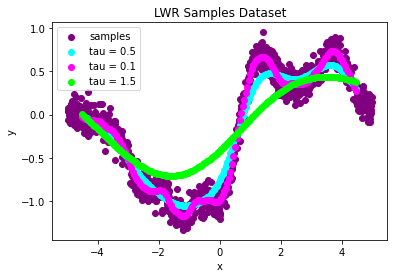

In [30]:
#TODO - Task 5, read in the artificial dataset, plot it, and run the code according to the above instructions.

lwr = np.load('LWR_Samples.npy')
x = lwr[:, 0]
y = lwr[:, 1]
plt.scatter(x, y, color='purple')

matrix = np.array([[x_i ** d for d in range(2)] for x_i in x])
matrix.reshape(len(x), 2)

lwr_model_1 = LocallyWeightedLR(matrix, y, 0.5)
preds_1 = []
for i in np.arange(-4.5, 4.5, 0.05):
    preds_1.append(lwr_model_1.predict(i))
plt.scatter(np.arange(-4.5, 4.5, 0.05), preds_1, color='cyan')

print("Theta Parameters")
print('x = 4:', lwr_model_1.compute_theta(4))
print('x = 0.5:', lwr_model_1.compute_theta(0.5))
print('x = -3:', lwr_model_1.compute_theta(-3))


lwr_model_2 = LocallyWeightedLR(matrix, y, 0.1)
preds_2 = []
for i in np.arange(-4.5, 4.5, 0.05):
    preds_2.append(lwr_model_2.predict(i))
plt.scatter(np.arange(-4.5, 4.5, 0.05), preds_2, color='magenta')

lwr_model_3 = LocallyWeightedLR(matrix, y, 1.5)
preds_3 = []
for i in np.arange(-4.5, 4.5, 0.05):
    preds_3.append(lwr_model_3.predict(i))
plt.scatter(np.arange(-4.5, 4.5, 0.05), preds_3, color='lime')

plt.title('LWR Samples Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['samples', 'tau = 0.5', 'tau = 0.1', 'tau = 1.5'], loc='best')
plt.show()

**Question 4**: 
 - Do the local linear regression parameters $\theta$ returned for the 3 input points (4, 0.5, -3) agree with what you expect, based on the training data in the neighborhood of those points? Why or why not?
 
Response: Yes, the parameters were similar to what I expected because the values correspond to the slope and y-intercept of the tangent line at each x-value. At x=-3, the slope is negative. At x=0.5, the slope is less negative and closer to 0. At x=4, the slope is negative and the tangent line has a positive y-intercept.


**Question 5:**  
 - Based on your observations, describe the effect of increasing and decreasing $\tau$, in the context of over/underfitting.
 
Response: When tau becomes too large, the resulting model is underfitted. When tau becomes too small, the resulting model is overfitted.

---
## Part 3: Submission 

Please upload a clean version of your work to Brightspace by the deadline.

Below, please acknowledge your collaborators as well as any resources/references (beyond guides to Python syntax) that you have used in this assignment: